# Projet 5 | Segmentez des clients d'un site e-commerce
## Partie 1 | Analyse Exploratoire

# Problématique

Olist souhaite que fournir à ses équipes d'e-commerce une segmentation des clients utilisable au quotidien pour leurs campagnes de communication.

# Objectifs

- Comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles

-  Fournir à l’équipe marketing une description actionnable de notre segmentation et de sa logique sous-jacente pour une utilisation optimale

- Réaliser une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps

# Sources

Nos données sont les données d'un client Brésilien, c'est un ensemble de dataset d'un site de e-commerce Brésilien. Ces datasets contiennent les données des commandes électroniques passées sur le site Brésilent Olist. Le jeu de données contient des informations sur 100000 commandes passées entre 2016 et 2018 sur plusieurs marchés au Brésil. Les différentes features présents dans le dataset permettent de visualiser une commande à partir sous plusieurs dimensions : statut de la commande, prix, paiement, performances du transport, l'emplacement du client, attributs du produit et aussi les avis rédigés par les clients.

Nos données sont dans des csv dans le dossier archive du répertoire courant. Ce dossier contient 9 csv.

• olist_customers_dataset.csv contient les informations clients.

• olist_geolocation_dataset.csv contient les informations sur la géolocalisation

• olist_order_items_dataset.csv contient les informations sur les items

• olist_order_payments_dataset.csv contient les informations sur les payements

• olist_order_reviews_dataset.csv contient les informations l'évaluation des produits

• olist_orders_dataset.csv contient les informations sur les achats

• olist_products_dataset.csv contient les informations sur les produits

• olist_sellers_dataset.csv contient les informations sur les vendeurs

• product_category_name_translation.csv contient les informations sur les catégories des produits

In [92]:
# installing chart_studio
!pip install chart_studio

## Import des packages

In [93]:
# Modules classiques d'analyse exploratoire:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj
import re

# Mathématiques
import math

# Manipulation fichiers et Interaction avec l'os / notebook
import os
import csv
import requests
import warnings
import json
import autopep8

# Manipulation de chaines de caractères
from ast import literal_eval 
#abstract syntax tree
from bs4 import BeautifulSoup as soup


# Manipulations temporelles
import datetime as dt
from tqdm import tqdm
from tqdm.notebook import tqdm, trange
import time

# Extraction web
from urllib.request import urlopen as uReq # Web client
import urllib.request # Web client
from importlib_metadata import version

# Feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.cluster import KMeans

## Importation des datasets 

In [94]:
# Infos sur les clients
customers = pd.read_csv("olist_customers_dataset.csv")
# Infos sur la géolocalisation
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
# Infos sur les items
items = pd.read_csv("olist_order_items_dataset.csv")
# Infos sur les payments
payments = pd.read_csv("olist_order_payments_dataset.csv")
# Infos sur l'évaluation des produits
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
# Infos sur les achats
orders = pd.read_csv("olist_orders_dataset.csv")
# Infos sur les produits
products = pd.read_csv("olist_products_dataset.csv")
# Infos sur les vendeurs
sellers = pd.read_csv("olist_sellers_dataset.csv")
# Infos sur les catégories des produits
category = pd.read_csv("product_category_name_translation.csv")

# 1.Description des Datasets

In [95]:
list_olist = {'customers', 'geolocation', 'items', 'payments',
           'reviews', 'orders', 'products', 'sellers', 'category'}

In [96]:
# for each dataframe show shape, missing, and column names
for df in list_olist:
    print(df, "="*55)
    print("lignes x colonnes =", eval(df).shape)
    print("manquants(%) = ", eval(df).isnull().mean().mean())
    print(eval(df).columns)
    print("#"*88)

payments =======================================================
lignes x colonnes = (103886, 5)
manquants(%) =  0.0
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
########################################################################################
sellers =======================================================
lignes x colonnes = (3095, 4)
manquants(%) =  0.0
Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')
########################################################################################
items =======================================================
lignes x colonnes = (112650, 7)
manquants(%) =  0.0
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
########################################################################################
orders =================

# 2.Nettoyage

## 2.1.Duplicates et valeurs manquantes

In [97]:
list_olist = [customers, geolocation, items, payments,
           reviews, orders, products, sellers, category]

In [98]:
# Les lignes repetées 
for df in list_olist:
    print(df.duplicated().sum())

0
261831
0
0
0
0
0
0
0


#### Observation :
- On remarque que juste la base geolocation contient des lignes en double

In [99]:
#Découverte des valeurs manquantes
for df in list_olist:
    print(df.isna().sum().sum())

0
0
0
0
145903
4908
2448
0
0


In [100]:
list_olist = ['customers', 'geolocation', 'items', 'payments',
           'reviews', 'orders', 'products', 'sellers', 'category']

## Vérifier les valeurs manquantes : 

#### Observation :
On remarque l'existance des valeurs manquantes dans les jeux de données suivants :

- reviews  (manquants(%) =   0.21006294560071875)
- orders   (manquants(%) =    0.006169487434760311)
- products (manquants(%) =   0.008254681193287004)

In [101]:
def valeurs_manquantes(D):
    return D.isna().sum()

## reviews (Les avis des clients)

In [102]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [103]:
reviews.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [104]:
valeurs_manquantes(reviews)

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

#### Observation :
- Commentaires manquants (au niveau de titre et message)

In [105]:
# on va remplacer les valeurs manquantes par des espaces (on met rien du tout )
reviews['review_comment_title'].fillna(' ', inplace=True)
reviews['review_comment_message'].fillna(' ', inplace=True)

In [106]:
reviews.isna().sum()

review_id                  0
order_id                   0
review_score               0
review_comment_title       0
review_comment_message     0
review_creation_date       0
review_answer_timestamp    0
dtype: int64

## orders (Les commandes)

In [107]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [108]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [109]:
valeurs_manquantes(orders)

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

signification de chaque variable

- order_id: Identifiant unique de la commande
- customer_id : Clé du jeu de données des clients. Chaque commande a un identifiant client unique.
- order_status : Référence au statut de la commande (livrée, expédiée, etc.)
- order_purchase_timestamp: Présente l'horodatage de l'achat
- order_approved_at : Présente l'horodatage de l'approbation du paiement datetime
- order_delivered_carrier_date : Présente l'horodatage de la commande. Il s'agit de la date à laquelle la commande a été traitée par le partenaire logistique.
- order_delivered_customer_date : Présente la date réelle de livraison de la commande au client
- order_estimated_delivery_date : Présente la date de livraison estimée qui a été communiquée au client au moment de l'achat

#### Observation :
- On remarque qu'il y a des valeurs manquantes  dans les dates des divers phases d'avancement des commandes.
 Il s'agit de commandes annulées, ou le processus n'a pas été bien suivi sur ses étapes.

In [110]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Les differents statuts d'avancement des commandes :

- delivered : livré
- shipped : expédié
- canceled : annulé
- unavailable : indisponible
- invoiced : facturé
- processing : en cours
- created : créé
- approved : approuvé

#### Observation :
- La majorité des commandes ont été livrées

In [111]:
orders['order_delivered_carrier_date'].fillna(0, inplace=True)
orders['order_delivered_customer_date'].fillna(0, inplace=True)

In [112]:
orders.isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                160
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
dtype: int64

## products (Les produits)

In [113]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [114]:
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [115]:
valeurs_manquantes(products)

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

signification de chaque variable: 

- product_id : identifiant unique du produit
- product_category_name : La catégorie de produit, en portugais
- product_name_lenght : nombre de caractères extraits du nom du produit
- product_description_lenght : nombre de caractères extraits de la description du produit
- product_photos_qty : nombre de photos de produits publiées
- product_weight_g : poids du produit mesuré en grammes
- product_length_cm : longueur du produit mesurée en centimètres
- product_height_cm : la hauteur du produit mesurée en centimètres
- product_width_cm : largeur du produit mesurée en centimètres

In [116]:
#on va supprimer les lignes avec 2 nan ( Ne seront pas utiles dans notre analyse)
products.dropna(subset=['product_weight_g','product_length_cm','product_height_cm','product_width_cm'],inplace=True)

In [117]:
#on va remplacer les nan de la categorie par unkwon
products['product_category_name'].fillna('Unkwown',inplace=True)
#on va remplacer les nan de la taille par  0
products['product_name_lenght'].fillna(0,inplace=True)
#on va remplacer les nan de la description par  0
products['product_description_lenght'].fillna(0,inplace=True)
#on va remplacer les nan de nombre de photos de produits par  0
products['product_photos_qty'].fillna(0, inplace=True)

In [118]:
products.isna().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

## geolocation(Localisation)

In [119]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [120]:
geolocation.shape

(1000163, 5)

In [121]:
geolocation.dtypes

geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

In [122]:
geolocation['geolocation_city'].value_counts()

sao paulo               135800
rio de janeiro           62151
belo horizonte           27805
são paulo                24918
curitiba                 16593
                         ...  
jacuípe                      1
mar vermelho                 1
quebrangulo                  1
poço das trincheiras         1
poxim                        1
Name: geolocation_city, Length: 8011, dtype: int64

#### Observation :
- On remarque qu'il y a une répétation au niveau de noms des villes (exemple sao paulo/são paulo)

In [123]:
#Suprresion des accents dess noms des villes
import unicodedata
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print (f"Durée d'exécution de {f.__name__}: {te-ts}s")
        return result

    return timed


def strip_accents(text):
    """
    Strip accents from input String.

        param text: The input string.
        type text: String.

    returns: The processed String.
    rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

In [124]:
geolocation.geolocation_city = geolocation.geolocation_city.apply(lambda x: strip_accents(x))

In [125]:
geolocation.duplicated().sum()

279668

In [126]:
#suppression des lignes répétées 
geolocation=geolocation.drop_duplicates()

In [127]:
geolocation.shape

(720495, 5)

# 3.Merge des Dataframe

On doit créer une base de données qui rassemble les informations nécessaires pour qu'on peut appliquer la méthode de clustering RFM.

## 3.1.Produits et catégories

In [128]:
# Jointures sur les produits et catégories
produits = pd.merge(products, category,
                    how="left",
                    on="product_category_name")

In [129]:
# On supprime les variables unitiles pour RFM

In [130]:
var_supp = ["product_category_name", "product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]

In [131]:
produits.drop(var_supp, axis=1, inplace=True)

In [132]:
# On renome product_category_name_english par product_category_name
produits = produits.rename(columns={"product_category_name_english":
                                    "product_category_name"})

In [133]:
produits.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,housewares


### Visualisation de répartition des catégories de produits

In [134]:
produits['product_category_name'].value_counts()

bed_bath_table               3029
sports_leisure               2867
furniture_decor              2657
health_beauty                2444
housewares                   2335
                             ... 
tablets_printing_image          9
fashion_childrens_clothes       5
home_comfort_2                  5
security_and_services           2
cds_dvds_musicals               1
Name: product_category_name, Length: 71, dtype: int64

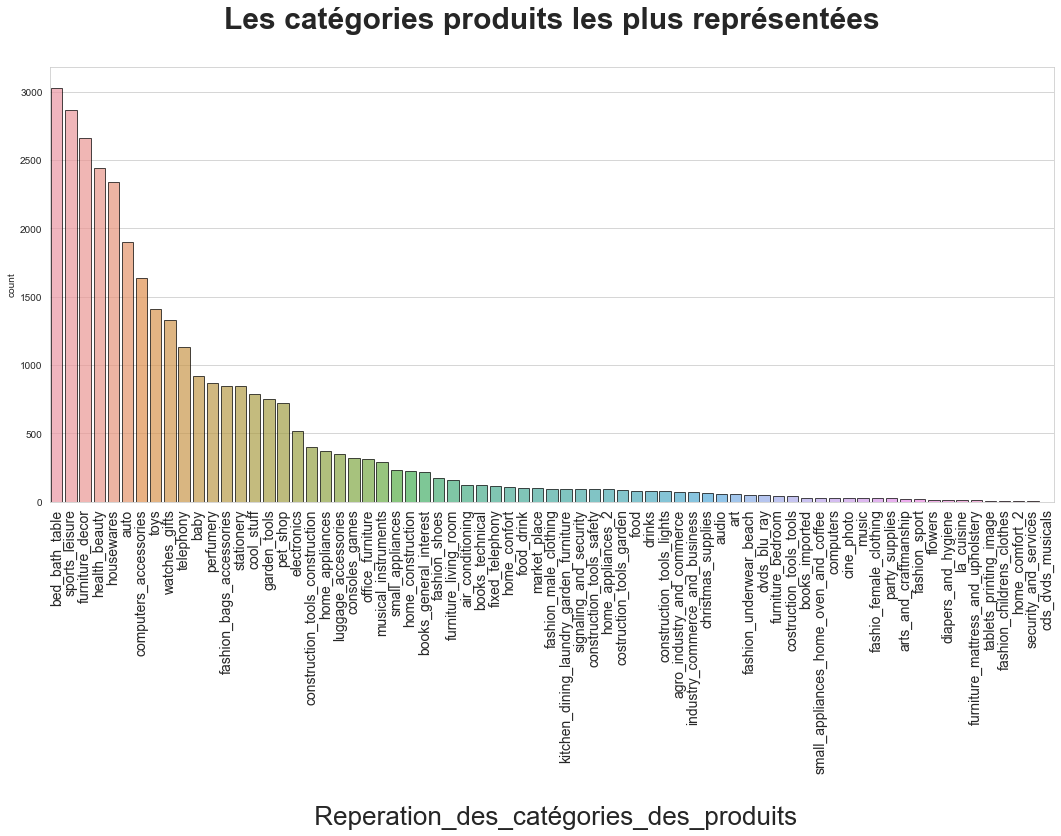

In [135]:
# Plot categories count in dataset
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("blue", reverse="True"))
font_title = {"weight": "bold",
              "size": 30}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=produits, x="product_category_name",
              edgecolor="black",
              order = produits['product_category_name'].value_counts().index,
              alpha=0.7)
plt.xticks(rotation=90, size=14)
plt.title(f"Les catégories produits les plus représentées\n",
          fontdict=font_title)
plt.xlabel('\n Reperation_des_catégories_des_produits', fontsize=26)
plt.show()

## 3.2.items et commandes

In [136]:
# Jointures sur les items et commandes
items = pd.merge(items, orders,
                       how="left",
                       on="order_id")

In [137]:
# On supprime les variables unitiles pour RFM
var_supp = ["seller_id", "shipping_limit_date","order_delivered_carrier_date",
                     "order_estimated_delivery_date"]
items.drop(var_supp, axis=1, inplace=True)

In [138]:
items.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

In [139]:
# On s'interesse juste par les commandes livrées
items = items[items["order_status"] == "delivered"]

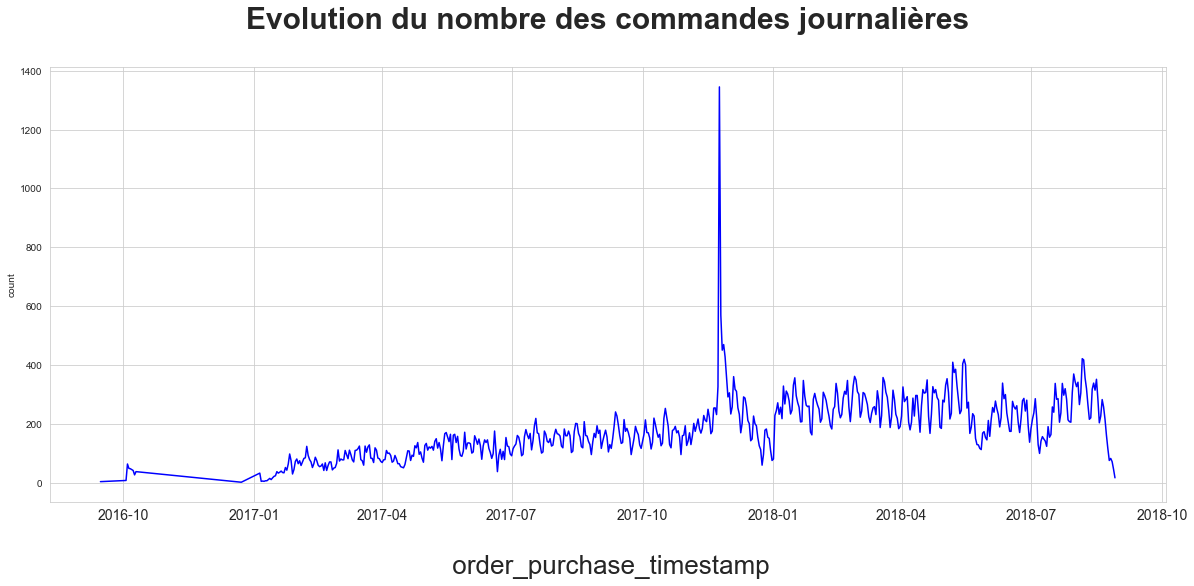

In [140]:
les_achats_journalieres = items.groupby(items["order_purchase_timestamp"]\
                                      .astype('datetime64[ns]').dt.date)\
                                    .count()["order_id"]
fig = plt.figure(figsize=(20, 8))
ax = les_achats_journalieres.plot(color='blue')
ax.set_ylabel("count")
plt.title(f"Evolution du nombre des commandes journalières\n",
          fontdict=font_title)
plt.xticks(size=14)
plt.xlabel('\n order_purchase_timestamp', fontsize=26)
plt.show()

#### Observation :
- On remarque une hausse des commandes (pic) autour de Novembre / Décembre 2017 (ce qui peut être un pic correspondant aux cadeaux de fin d'année) ainsi qu'un plateau sans commandes entre Octobre 2016 et Janvier 2017.

In [141]:
## Transformer les variables représentant des dates/heures en Datetime

In [142]:
datetime_cols = ["order_purchase_timestamp", "order_delivered_customer_date","order_approved_at" ]
for col in datetime_cols:
    items[col] = items[col].astype('datetime64[ns]')
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_approved_at              110182 non-null  datetime64[ns]
 9   order_delivered_customer_date  110197 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 

### Visualisation de la répartition du nombre de commandes par (mois/ jour de la semaine / heure du journée)

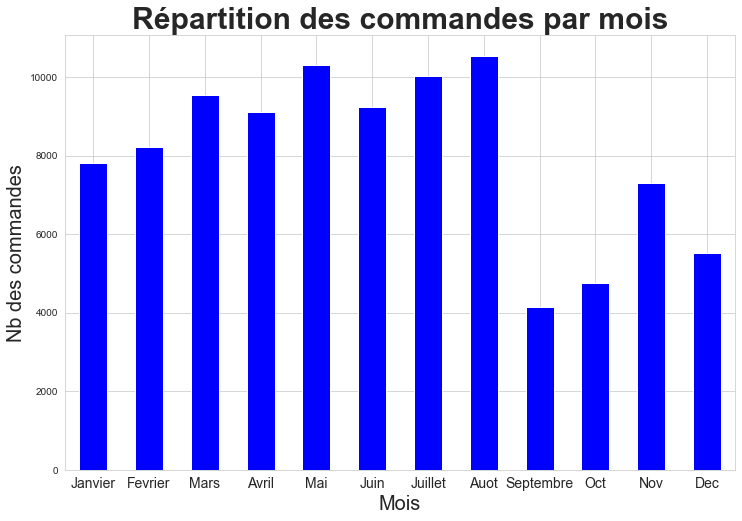

In [143]:
items.groupby(items['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          legend=False)
plt.xticks(np.arange(0,12), ['Janvier','Fevrier','Mars','Avril','Mai','Juin',
                             'Juillet','Auot','Septembre','Oct','Nov','Dec'], 
           rotation='horizontal')
plt.title("Répartition des commandes par mois",fontdict = font_title)
plt.xlabel('Mois', fontsize=20)
plt.ylabel('Nb des commandes', fontsize=20)
plt.xticks(size=14)
plt.show()

### Observation 
-  On remarque qu'il y a plus des commandes pendant les mois : Aout/Juillet/ Mai et Mars

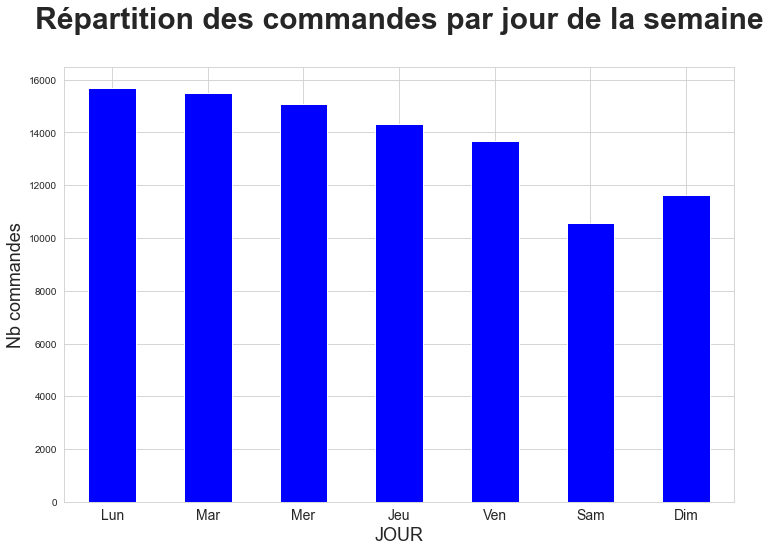

In [144]:
items.groupby(items['order_purchase_timestamp'].dt.dayofweek)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          legend=False)
plt.xticks(np.arange(0,7), ['Lun','Mar','Mer','Jeu','Ven','Sam','Dim'], rotation='horizontal')
plt.title(f"Répartition des commandes par jour de la semaine\n",fontdict = font_title)
plt.xlabel('JOUR', fontsize=18)
plt.ylabel('Nb commandes', fontsize=18)
plt.xticks(size=14)
plt.show()

### Observation 
-  On remarque que au debut de la semaine il y a plus des commandes que la fin de la semaine .

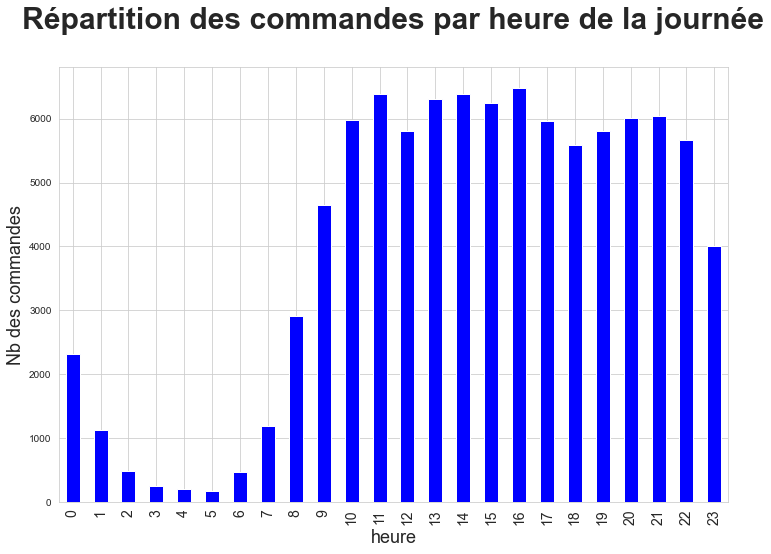

In [145]:
items.groupby(items['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          legend=False)
plt.title(f"Répartition des commandes par heure de la journée\n",fontdict = font_title)
plt.xlabel('heure', fontsize=18)
plt.ylabel('Nb des commandes', fontsize=18)
plt.xticks(size=14)
plt.show()

### Observation :
-  On remarque que a partir de 10h jusqu'a 23h il y a une augmentation de nombre des commandes

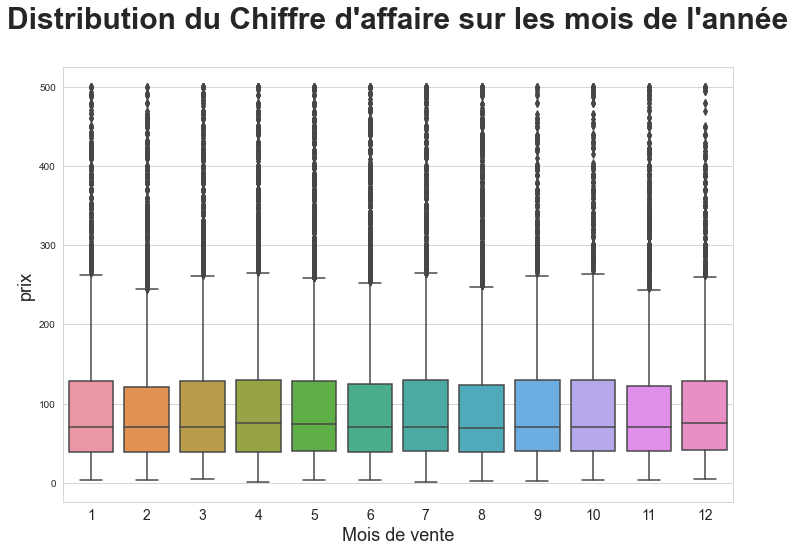

In [146]:
items["sale_month"] = items['order_purchase_timestamp'].dt.month
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=items[items.price < 500], x="sale_month", y="price")
plt.title(f"Distribution du Chiffre d'affaire sur les mois de l'année\n",fontdict = font_title)
plt.xlabel('Mois de vente', fontsize=18)
plt.ylabel('prix', fontsize=18)
plt.xticks(size=14)
plt.show()

### Observation :
-  Les médianes et variances restent très proche sur les différents mois de l'année. Nous intégrerons tout de même cette donnée pour le moment mais il sera judicieux de regarder l'évolution de cette distribution pour l'intégrer dans le cadre du contrat de maintenance.

## 3.3.items et payments

In [147]:
# Jointure items et payments
group_payments = payments.groupby(by="order_id").agg(
    {"payment_sequential": 'count',
     "payment_installments": 'sum'})

items = pd.merge(items, group_payments,
                       how="left",
                       on="order_id")
items = items.rename(columns={
    "payment_sequential": "nb_payment_sequential",
    "payment_installments": "sum_payment_installments"})

In [148]:
# pourcentage par type de paiement
type_paiement = payments.groupby('payment_type')['order_id'] \
    .count()
df_paiement = pd.DataFrame({'Type paiement': type_paiement
                                 .index,
                                 'Nb_par_type': type_paiement
                                 .values})
nb_tot = df_paiement['Nb_par_type'].sum()
df_paiement['%'] = \
    round((df_paiement['Nb_par_type']*100)/nb_tot, 3)
df_paiement.sort_values(by='%', ascending=False)

,Type paiement,Nb_par_type,%
1,credit_card,76795,73.922
0,boleto,19784,19.044
4,voucher,5775,5.559
2,debit_card,1529,1.472
3,not_defined,3,0.003


### Visualisation de la répartition des moyens de paiement utilisés

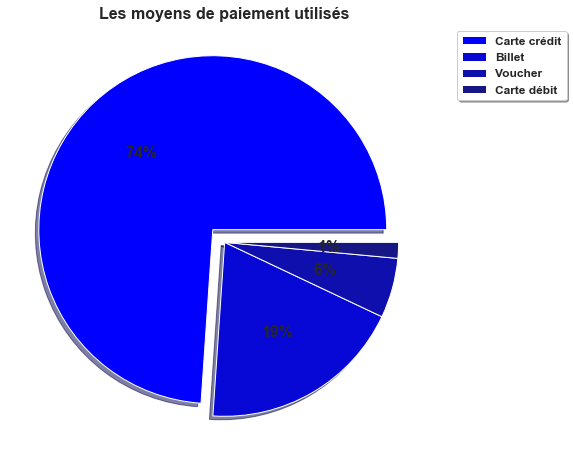

In [149]:
fig, ax = plt.subplots(figsize=(9, 8), subplot_kw=dict(aspect='equal'))
explode = (0.1, 0, 0, 0)
legend = ['Carte crédit', 'Billet', 'Voucher',
          'Carte débit']

p =payments['payment_type'][payments['payment_type'] != 'not_defined'].value_counts()
p.plot(kind="pie", legend=False, labels=None, startangle=0,
       explode=explode, autopct='%1.0f%%', pctdistance=0.6, shadow=True,
       textprops={'weight': 'bold', 'fontsize': 16}, 
       ax=ax)
ax.legend(legend, loc='best', shadow=True,
          prop={'weight': 'bold', 'size': 12},
          bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.title('Les moyens de paiement utilisés', fontweight='bold', size=16)
plt.ylabel("")
plt.show()

### Observation :
- On remarque que 74% des paiements environ sont réalisés en carte bancaire.

## 3.4.items et les avis

In [150]:
## Jointure items et reviews
list_reviews = reviews.groupby("order_id").agg({
    "review_id": "count",
    "review_score": "mean"})

items = pd.merge(items, list_reviews,
                       how="left",
                       on="order_id")
items = items.rename(columns={
    "review_id": "is_reviewed"})

In [151]:
items["is_reviewed"] = np.where(items["is_reviewed"] == 1,
                                      True, False)

## Visualisation de la répartion des notes attribuées aux commandes 

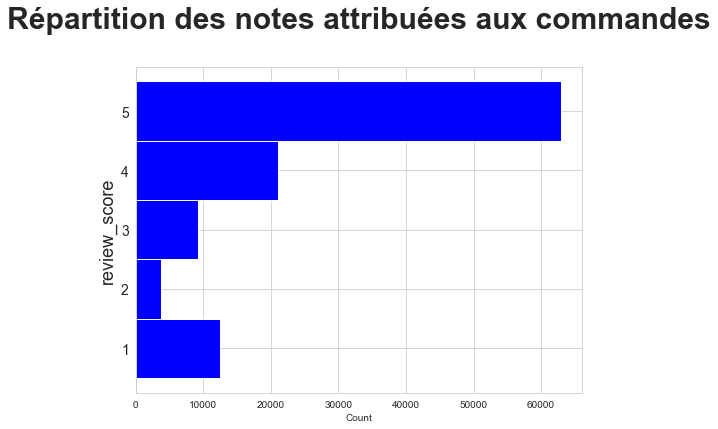

In [152]:
fig = plt.figure(figsize=(8, 6))
sns.histplot(data=items, y="review_score", 
             discrete=True, alpha=1)
plt.title(f"Répartition des notes attribuées aux commandes\n",
          fontdict=font_title)
plt.ylabel('review_score', fontsize=18)
plt.yticks(size=14)
plt.show()

### Obsevation :
- satisfaction dans l'ensemble

## 3.5.items et les clients

In [153]:
##Jointure items et customers
items = pd.merge(items, customers,how="left",on="customer_id")

## 3.6 Création du dataset final

In [154]:
data_global = pd.merge(items, products,how="left",on="product_id")

In [155]:
data_global.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,...,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,...,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,...,para de minas,MG,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,...,atibaia,SP,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,...,varzea paulista,SP,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0


In [156]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 110196
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_approved_at              110182 non-null  datetime64[ns]
 9   order_delivered_customer_date  110197 non-null  datetime64[ns]
 10  sale_month                     110197 non-null  int64         
 11  

In [157]:
data_global.isna().sum()

order_id                           0
order_item_id                      0
product_id                         0
price                              0
freight_value                      0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                 15
order_delivered_customer_date      0
sale_month                         0
nb_payment_sequential              3
sum_payment_installments           3
is_reviewed                        0
review_score                     827
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
product_category_name             18
product_name_lenght               18
product_description_lenght        18
product_photos_qty                18
product_weight_g                  18
product_length_cm                 18
product_height_cm                 18
product_width_cm                  18
d

In [158]:
data_global.dropna(inplace= True, how='any')

## 4.Sélection des variables pertinentes ("Feature selection") 

In [159]:
data_global_final = data_global[['order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_customer_date', 'sale_month', 'nb_payment_sequential',
       'sum_payment_installments', 'is_reviewed', 'review_score',
       'customer_unique_id', 'customer_city',
       'customer_state', 'product_category_name']]

In [160]:
data_global_final.head()

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,customer_unique_id,customer_city,customer_state,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,9,1.0,2.0,True,5.0,871766c5855e863f6eccc05f988b23cb,campos dos goytacazes,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,4,1.0,3.0,True,4.0,eb28e67c4c0b83846050ddfb8a35d051,santa fe do sul,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,1,1.0,5.0,True,5.0,3818d81c6709e39d06b2738a8d3a2474,para de minas,MG,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,8,1.0,2.0,True,4.0,af861d436cfc08b2c2ddefd0ba074622,atibaia,SP,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,2,1.0,3.0,True,5.0,64b576fb70d441e8f1b2d7d446e483c5,varzea paulista,SP,ferramentas_jardim


In [161]:
data_global_final.describe()

,order_item_id,price,freight_value,sale_month,nb_payment_sequential,sum_payment_installments,review_score
count,109334.000000,109334.000000,109334.000000,109334.000000,109334.000000,109334.000000,109334.000000
mean,1.195612,119.868396,19.946145,6.031509,1.043948,3.063201,4.082053
std,0.690557,181.031686,15.691870,3.228839,0.377442,2.826058,1.345843
min,1.000000,0.850000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,39.900000,13.080000,3.000000,1.000000,1.000000,4.000000
50%,1.000000,74.900000,16.260000,6.000000,1.000000,2.000000,5.000000
75%,1.000000,134.200000,21.150000,8.000000,1.000000,4.000000,5.000000
max,21.000000,6735.000000,409.680000,12.000000,26.000000,26.000000,5.000000


order_id                         0.0
order_item_id                    0.0
product_id                       0.0
price                            0.0
freight_value                    0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_customer_date    0.0
sale_month                       0.0
nb_payment_sequential            0.0
sum_payment_installments         0.0
is_reviewed                      0.0
review_score                     0.0
customer_unique_id               0.0
customer_city                    0.0
customer_state                   0.0
product_category_name            0.0
dtype: float64

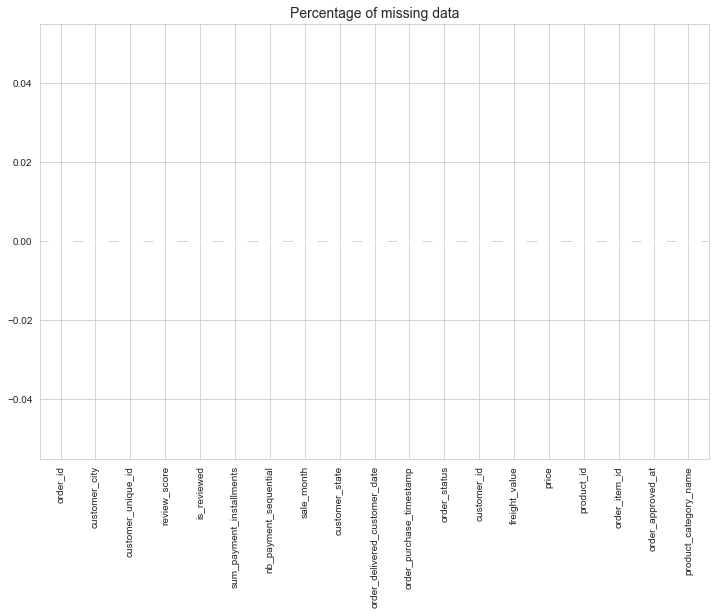

In [162]:
missing_data = round(data_global_final.isna().sum()*100/len(data_global_final),1)
ax = missing_data.sort_values().plot.bar(figsize=(12,8),color="coral",width=0.7)
ax.set_title("Percentage of missing data", fontsize=14)
missing_data

## 5. Calcul de la "Récence", "Fréquence", "Montant" :

La segmentation RFM (Recency, Frequency, Montant) est utilisé en marketing. Elle permet un classement des clients en fonction de leurs habitudes d'achat. On peut ainsi optimiser une stratégie marketing en fonction de nos clients. La segmentation RFM se base sur des habitudes de consommations comme la date du dernier achat (Recence), la fréquence d'achat (Frequence) et le montant dépensé lors d'une commande (Montant).

## Nombre de commandes par client

In [163]:
print("La base de données finale compte {} clients".format(data_global_final.customer_unique_id.unique().shape[0]))

La base de données finale compte 92728 clients


In [164]:
data_global_final.groupby("customer_unique_id").agg({"order_id": "nunique"}).value_counts()
             

order_id
1           89968
2            2538
3             175
4              28
5               9
6               5
7               3
9               1
15              1
dtype: int64

In [165]:
dt = data_global_final.groupby("customer_unique_id").agg({"order_id": "nunique"}).value_counts()


In [166]:
dt.sum()

92728

In [167]:
commande_per = dt*100/dt.sum()
commande_per

order_id
1           97.023553
2            2.737037
3            0.188724
4            0.030196
5            0.009706
6            0.005392
7            0.003235
9            0.001078
15           0.001078
dtype: float64

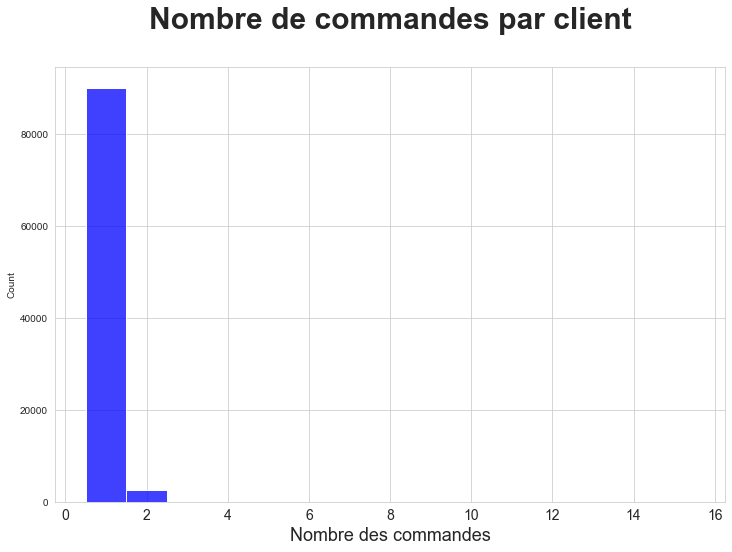

In [168]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data_global_final.groupby("customer_unique_id").agg({"order_id": "nunique"}),
             x="order_id",
             discrete=True)
plt.xlabel("Nombre des commandes", fontsize=18)
plt.title(f"Nombre de commandes par client\n",
          fontdict=font_title)
plt.xticks(size=14)
plt.show()

### Observation :
- On remarque que 97% des clients ont passés une seule commande et seulement 3% ont passés plus que une commande  

## Nombre moyen d'articles par commande

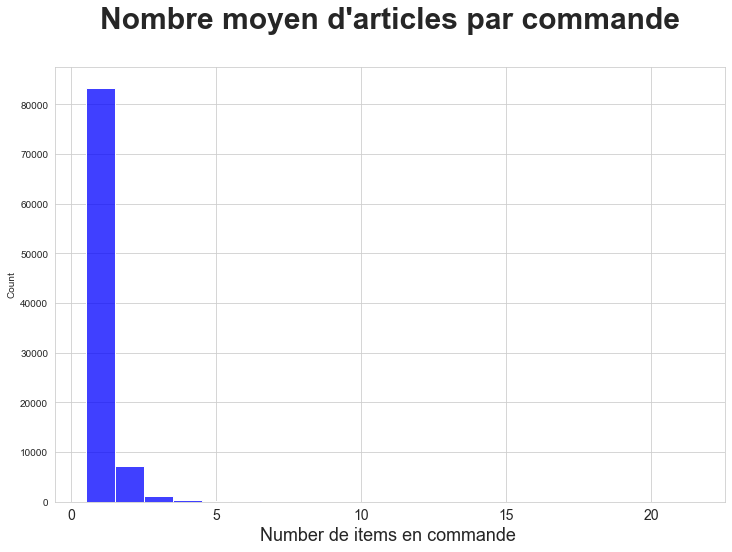

In [169]:
produit_par_commande = data_global_final.groupby(["customer_unique_id", "order_id"])\
                        .agg({"order_item_id": "count"})
produit_par_commande = produit_par_commande.groupby("customer_unique_id")\
                        .agg({"order_item_id": "mean"})

# Plot densité de items en commande
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = produit_par_commande,
             x="order_item_id",
             discrete=True)
plt.xlabel("Number de items en commande ", fontsize=18)
plt.title(f"Nombre moyen d'articles par commande\n",
          fontdict=font_title)
plt.xticks(size=14)
plt.show()

### Origines des clients

### Répartition des clients par Etats

In [170]:
city_client = data_global_final.customer_city.value_counts()[:6]

Text(0.5, 1.0, "L'origine des clients")

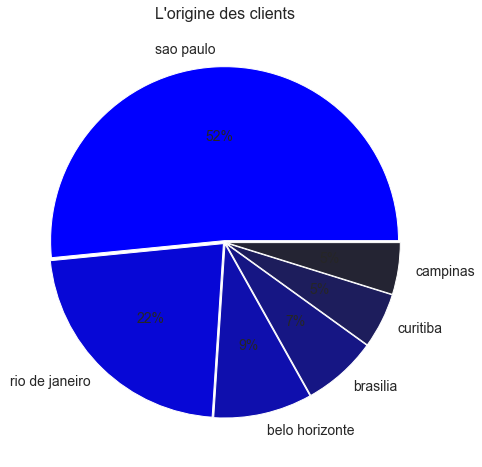

In [171]:
fig, ax = plt.subplots(figsize =(12, 8))
ax.pie(city_client, labels = city_client.index, autopct = '%.0f%%',explode=[0.01]*6,textprops={'fontsize': 14})
ax.set_title("L'origine des clients",fontsize=16)

### 5.1 Montant total d'achats

In [172]:
data_global_final = data_global_final.rename(columns={"price":"Montant"})

In [173]:
Montant = data_global_final.groupby(by="customer_unique_id").sum()
Montant = Montant.sort_values(by="Montant",ascending=False)

Text(0.5, 1.0, "Le montant total payé par chaque client pour l'ensemble des achats effectués")

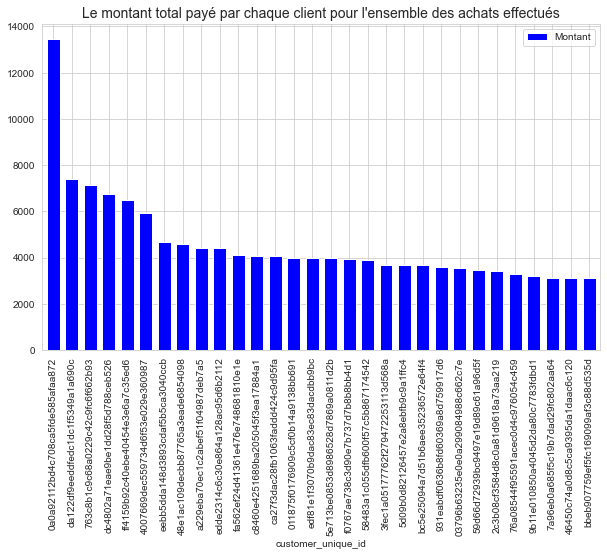

In [174]:
ax = Montant[:30].plot.bar(y="Montant",figsize=(10,6),color="blue",width=0.7)
ax.set_title("Le montant total payé par chaque client pour l'ensemble des achats effectués", fontsize=14)

[Text(0.5, 1.0, "box plot des montants payés par les clients sur l'ensemble des achats")]

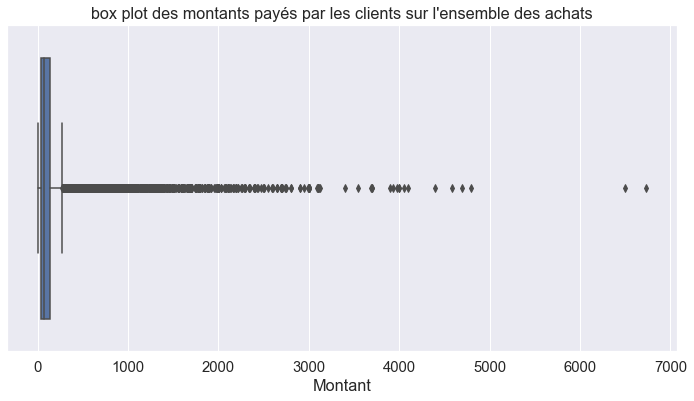

In [175]:
plt.figure(figsize=(12,6))
sns.set(font_scale = 1.35)

sns.boxplot(x="Montant",data=data_global_final).set(title="box plot des montants payés par les clients sur l'ensemble des achats")

### 5.2 Fréquence d'achats

In [176]:
frequence = pd.DataFrame(data_global_final.customer_unique_id.value_counts().reset_index())

In [177]:
frequence.columns=["customer_unique_id","Frequence"]

Text(0.5, 1.0, "Le nombre total d'achats par chaque client")

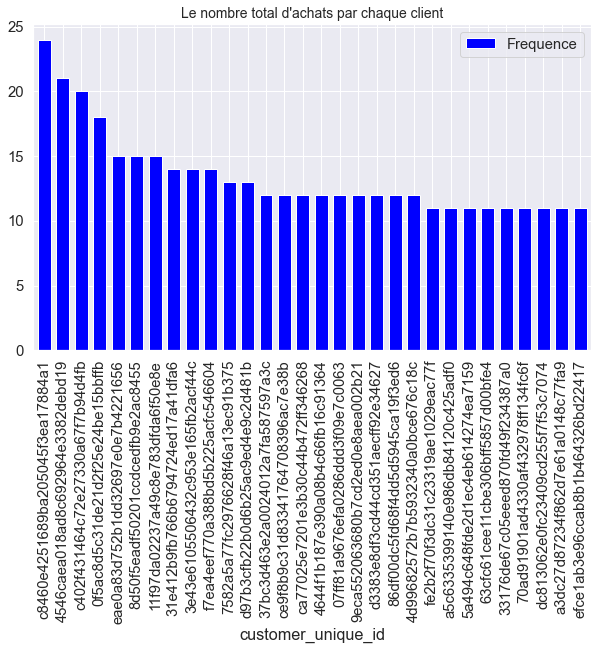

In [178]:
ax = frequence[:30].plot.bar(x="customer_unique_id", y="Frequence",figsize=(10,6),color="blue",width=0.7)
ax.set_title("Le nombre total d'achats par chaque client", fontsize=14)

<AxesSubplot:xlabel='Frequence'>

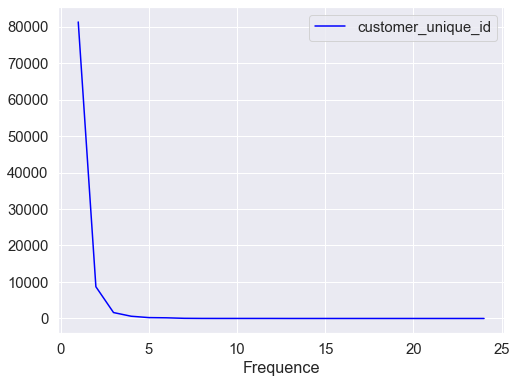

In [179]:
frequence.groupby("Frequence").count().plot(figsize=(8,6),color="blue")

### Nombre des produits achetés par client

In [180]:
cust_total_price = data_global_final.groupby(by="customer_unique_id").sum()

In [181]:
cust_total_price = cust_total_price.reset_index()

In [182]:
cluster_table = pd.merge(cust_total_price,frequence,on="customer_unique_id")

In [183]:
cluster_table = cluster_table.sort_values(by="Frequence",ascending=False)

In [184]:
cluster_table.head(3)

,customer_unique_id,order_item_id,Montant,freight_value,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,Frequence
72630,c8460e4251689ba205045f3ea17884a1,84,4080.0,575.88,192,24.0,144.0,24,96.0,24
25141,4546caea018ad8c692964e3382debd19,231,31.8,164.37,147,21.0,42.0,21,21.0,21
71086,c402f431464c72e27330a67f7b94d4fb,210,2000.0,202.40,40,20.0,20.0,20,20.0,20


Text(0.5, 1.0, 'Le nombre total de produits achetés par chaque client')

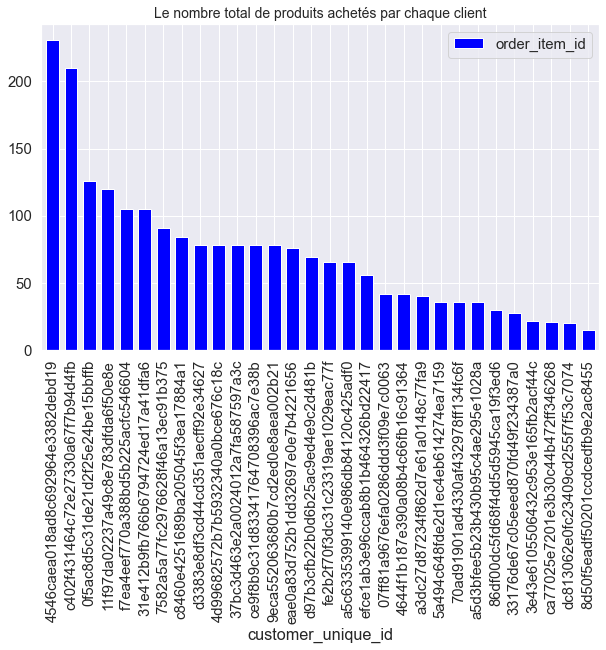

In [185]:
ax = cluster_table[:30].sort_values(by="order_item_id",ascending=False).plot.bar(x="customer_unique_id", y="order_item_id",figsize=(10,6),color="blue",width=0.7)
ax.set_title("Le nombre total de produits achetés par chaque client", fontsize=14)

<AxesSubplot:xlabel='order_item_id'>

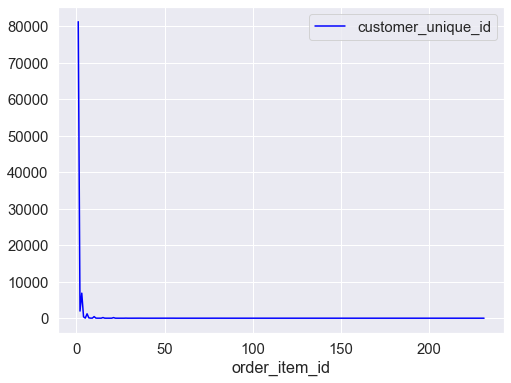

In [186]:
oi = cluster_table[["customer_unique_id","order_item_id"]]
oi.groupby("order_item_id").count().plot(figsize=(8,6),color="blue")

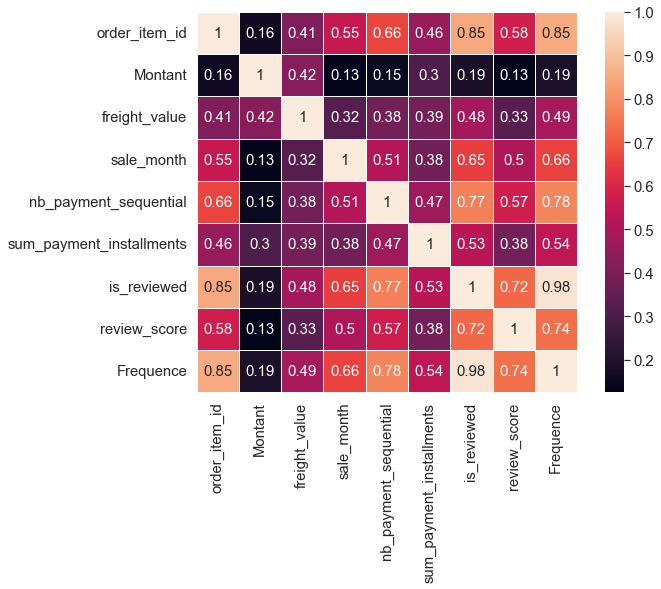

In [187]:
plt.figure(figsize=(10, 7))
sns.heatmap(cluster_table.corr(), annot=True, square=True, linewidths=.5, annot_kws={"size":15})
plt.show()

In [188]:
cluster_table.head(5)

,customer_unique_id,order_item_id,Montant,freight_value,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,Frequence
72630,c8460e4251689ba205045f3ea17884a1,84,4080.00,575.88,192,24.0,144.0,24,96.0,24
25141,4546caea018ad8c692964e3382debd19,231,31.80,164.37,147,21.0,42.0,21,21.0,21
71086,c402f431464c72e27330a67f7b94d4fb,210,2000.00,202.40,40,20.0,20.0,20,20.0,20
5591,0f5ac8d5c31de21d2f25e24be15bbffb,126,1252.35,292.47,198,18.0,153.0,18,90.0,18
85181,eae0a83d752b1dd32697e0e7b4221656,76,1821.73,961.28,38,15.0,134.0,15,45.0,15


### 5.3 Récence

In [189]:
# la plus vieille date de commande 
print(data_global_final["order_purchase_timestamp"].min())
# la plus récente date de commande
print(data_global_final["order_purchase_timestamp"].max())

2016-10-03 09:44:50
2018-08-29 15:00:37


In [190]:
date = data_global_final[["customer_unique_id","order_approved_at"]]

In [191]:
date.head(5)

,customer_unique_id,order_approved_at
0,871766c5855e863f6eccc05f988b23cb,2017-09-13 09:45:35
1,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 11:05:13
2,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:48:30
3,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:10:18
4,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 14:10:13


### Transformation des dates d'achats en nombre de jours écoulés 

In [192]:
today = pd.to_datetime("2023-01-11")
dt = date.copy()
dt["Récence"] = (today - date["order_approved_at"]).dt.days

**On va garder  juste  la date d'achat la plus récente pour distinguer les nouveaux et les anciens cliens**

In [193]:
dt = dt.groupby("customer_unique_id").agg("min").reset_index()

In [194]:
cluster_table_final = pd.merge(cluster_table,dt,on="customer_unique_id")

In [195]:
cluster_table_final.head(5)

,customer_unique_id,order_item_id,Montant,freight_value,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,Frequence,order_approved_at,Récence
0,c8460e4251689ba205045f3ea17884a1,84,4080.00,575.88,192,24.0,144.0,24,96.0,24,2018-08-08 09:05:09,1615
1,4546caea018ad8c692964e3382debd19,231,31.80,164.37,147,21.0,42.0,21,21.0,21,2017-07-17 18:25:23,2003
2,c402f431464c72e27330a67f7b94d4fb,210,2000.00,202.40,40,20.0,20.0,20,20.0,20,2018-02-24 03:20:27,1781
3,0f5ac8d5c31de21d2f25e24be15bbffb,126,1252.35,292.47,198,18.0,153.0,18,90.0,18,2017-11-24 10:31:10,1870
4,eae0a83d752b1dd32697e0e7b4221656,76,1821.73,961.28,38,15.0,134.0,15,45.0,15,2018-02-01 19:37:42,1721


### 5.4 Score d'avis

On va attribuer un score d'avis moyen pour chaque client qui correspond à la moyenne des avis du client pour chacune de ces commandes effectuées. Le score va etre arrondi.

# cluster_table_final["Avis"]

In [196]:
cluster_table_final["Avis"] = round(cluster_table_final["review_score"] / \
                                           cluster_table_final["Frequence"])

In [197]:
cluster_table_final = cluster_table_final[["customer_unique_id","Montant","Frequence","Récence","Avis"]]

In [198]:
cluster_table_final.head(5)

,customer_unique_id,Montant,Frequence,Récence,Avis
0,c8460e4251689ba205045f3ea17884a1,4080.00,24,1615,4.0
1,4546caea018ad8c692964e3382debd19,31.80,21,2003,1.0
2,c402f431464c72e27330a67f7b94d4fb,2000.00,20,1781,1.0
3,0f5ac8d5c31de21d2f25e24be15bbffb,1252.35,18,1870,5.0
4,eae0a83d752b1dd32697e0e7b4221656,1821.73,15,1721,3.0


In [199]:
cluster_table_final.Frequence.agg(["min","max"])

min     1
max    24
Name: Frequence, dtype: int64

In [200]:
cluster_table_final.Avis.agg(["min","max"])

min    1.0
max    5.0
Name: Avis, dtype: float64

In [201]:
cluster_table_final.Montant.agg(["min","max"])

min        0.85
max    13440.00
Name: Montant, dtype: float64

In [202]:
cluster_table_final["Récence"].min()

1595

In [203]:
cluster_table_final["Récence"].max()

2289

### Nombre d'achats total en fonction du temps

Text(0.5, 1.0, "Evolution du nombre d'achats en fonction du temps")

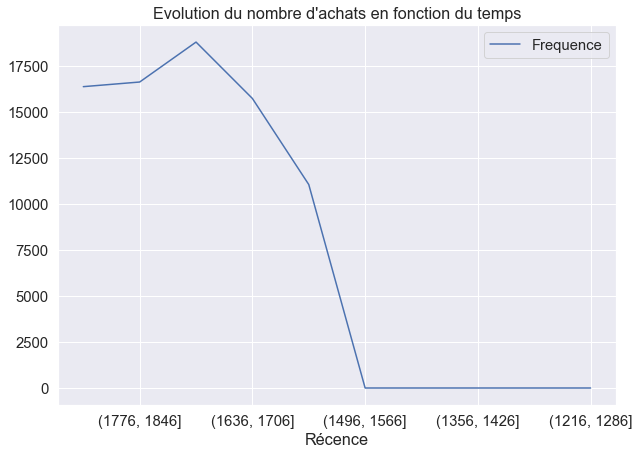

In [204]:
achats_temps = cluster_table_final.groupby(pd.cut(cluster_table_final["Récence"], np.arange(1216,1917,70))).sum()
achats_temps = achats_temps[["Frequence"]]

ax = achats_temps.plot(figsize=(10,7))
ax.invert_xaxis()
plt.title("Evolution du nombre d'achats en fonction du temps")

In [205]:
achats_temps = cluster_table_final.groupby(pd.cut(cluster_table_final["Récence"], np.arange(1216,1917,10))).sum()
achats_temps = achats_temps[["Frequence"]]

Text(0.5, 1.0, "Evolution du nombre d'achats en fonction du temps")

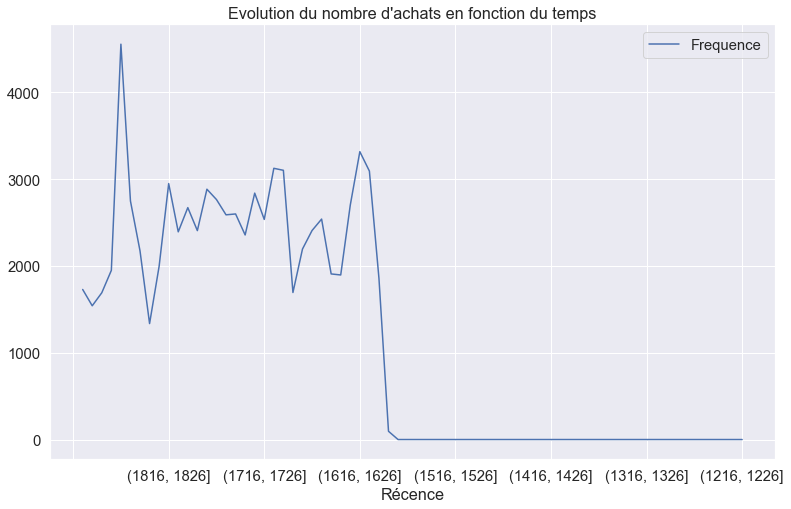

In [206]:
ax = achats_temps.plot(figsize=(13,8))
ax.invert_xaxis()
plt.title("Evolution du nombre d'achats en fonction du temps")

## 6. EXPORT DES DONNÉES

In [207]:
#Sauvegarde de la base de données finale  
cluster_table_final.to_csv("Data_cleaned")